# Loan Approval Prediction with Python

Loan approvals are an everyday task in banks and fintech companies. Instead of just relying on human judgment, we can use machine learning to support decisions. The idea is simple: based on an applicant’s financial history, income, credit score, and other attributes, we can predict whether their loan will get approved or not.

In this notebook, I’ll walk you step by step through **Loan Approval Prediction** using Python. We’ll load and clean the dataset, do some exploratory analysis with plots, and finally train a machine learning model to make predictions.

---

## Dataset

The dataset includes information about loan applicants, such as gender, marital status, income, employment status, credit history, and whether the loan was approved.


In [252]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Load dataset
df = pd.read_csv("loan_prediction.csv")
print(df.head())

    Loan_ID Gender Married Dependents     Education Self_Employed  \
0  LP001002   Male      No          0      Graduate            No   
1  LP001003   Male     Yes          1      Graduate            No   
2  LP001005   Male     Yes          0      Graduate           Yes   
3  LP001006   Male     Yes          0  Not Graduate            No   
4  LP001008   Male      No          0      Graduate            No   

   ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0             5849                0.0         NaN             360.0   
1             4583             1508.0       128.0             360.0   
2             3000                0.0        66.0             360.0   
3             2583             2358.0       120.0             360.0   
4             6000                0.0       141.0             360.0   

   Credit_History Property_Area Loan_Status  
0             1.0         Urban           Y  
1             1.0         Rural           N  
2             1.0   

In [253]:
# We’ll drop the `Loan_ID` column because it doesn’t help in prediction:
df = df.drop('Loan_ID', axis=1)

## Checking Missing Values

Let’s see how many missing values we have:

In [254]:
print(df.isnull().sum())

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


We can see missing values in both categorical and numerical columns. Let’s fill them appropriately:

In [255]:
# Fill categorical with mode
for col in ['Gender','Married','Dependents','Self_Employed']:
    df[col] = df[col].fillna(df[col].mode()[0])

# Fill numerical with median or mode
df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].median())
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0])
df['Credit_History'] = df['Credit_History'].fillna(df['Credit_History'].mode()[0])

## Exploratory Data Analysis (EDA)
### Loan Status Distribution

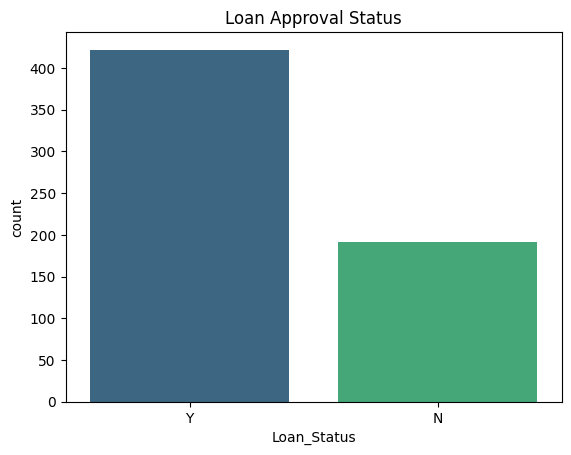

In [256]:
sns.countplot(x="Loan_Status", data=df, hue="Loan_Status", palette="viridis", legend= False)
plt.title("Loan Approval Status")
plt.show()

Most applicants got their loans approved (Y), but there is still a significant portion who got rejected (N).

### Gender Distribution

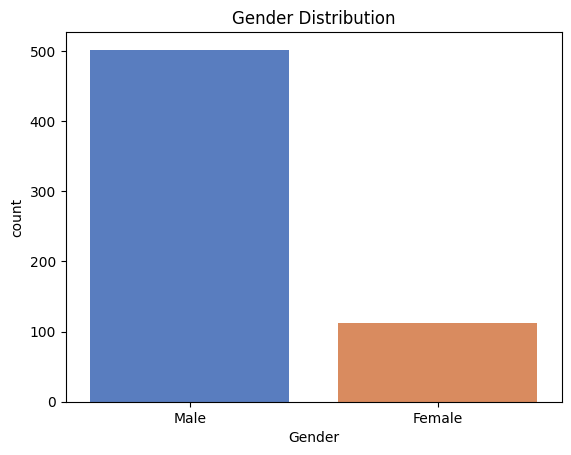

In [257]:
sns.countplot(x="Gender", hue="Gender", data=df, palette="muted", legend=False)
plt.title("Gender Distribution")
plt.show()

The dataset has more male applicants than female ones.

### Marital Status Distribution

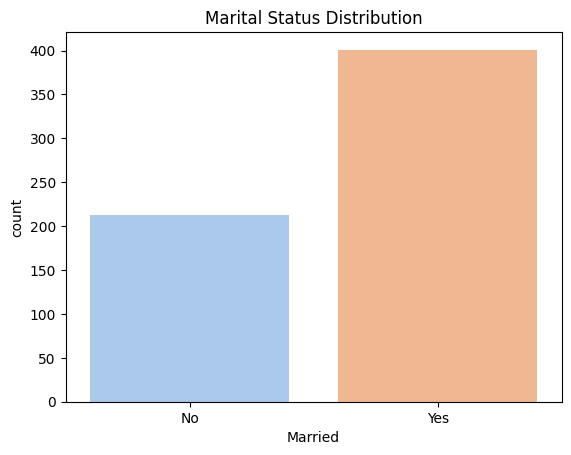

In [258]:
sns.countplot(x="Married", hue="Married", data=df, palette="pastel", legend=False)
plt.title("Marital Status Distribution")
plt.show()

A higher proportion of loan applicants are married compared to unmarried applicants.

### Education Distribution

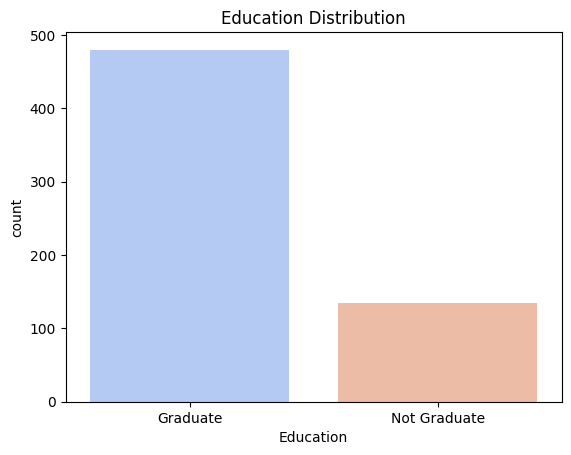

In [259]:
sns.countplot(x="Education", hue="Education", data=df, palette="coolwarm", legend=False)
plt.title("Education Distribution")
plt.show()

Graduates dominate the dataset, showing that many applicants have a university-level education.

### Self-Employed Distribution

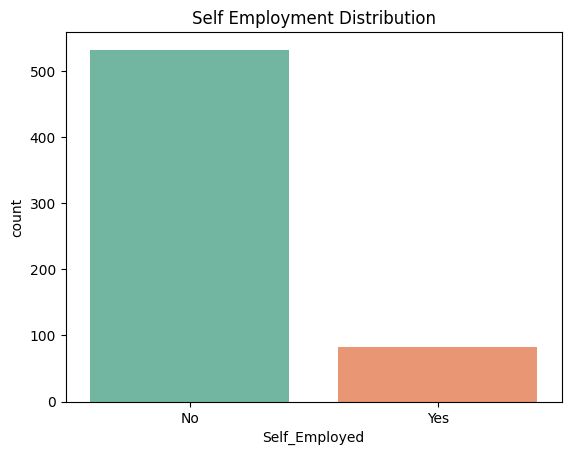

In [260]:
sns.countplot(x="Self_Employed", hue="Self_Employed", data=df, palette="Set2", legend=False)
plt.title("Self Employment Distribution")
plt.show()

Most applicants are not self-employed, meaning salaried jobs are more common in this dataset.

### Applicant Income

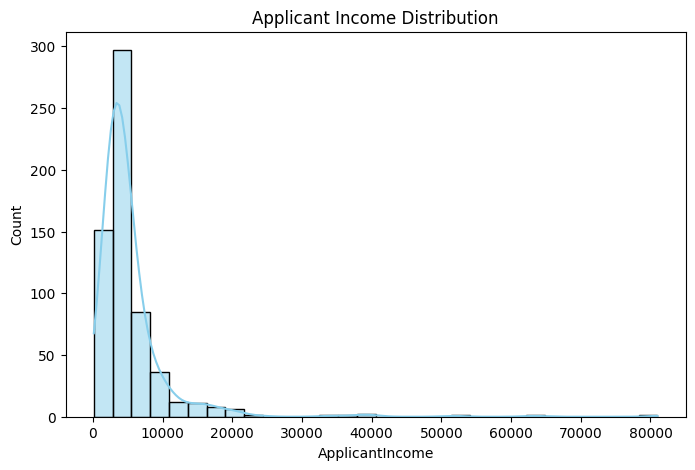

In [261]:
plt.figure(figsize=(8,5))
sns.histplot(df["ApplicantIncome"], bins=30, kde=True, color="skyblue")
plt.title("Applicant Income Distribution")
plt.show()

Applicant incomes are highly skewed, with most applicants earning in the lower range and a few earning extremely high amounts (outliers).

### Loan\_Status vs ApplicantIncome

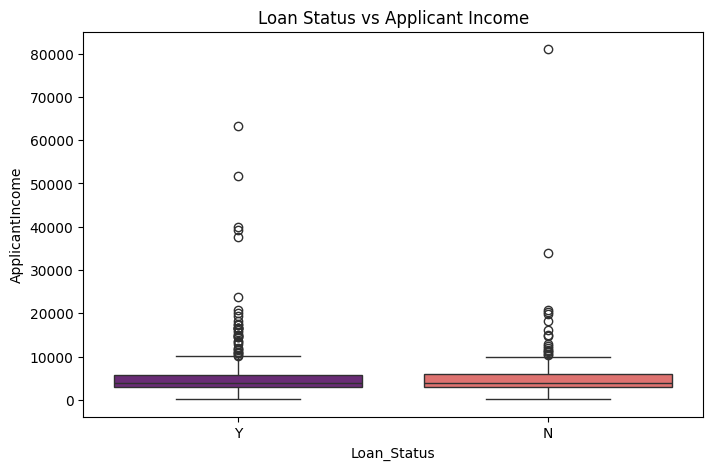

In [262]:
plt.figure(figsize=(8,5))
sns.boxplot(x="Loan_Status", y="ApplicantIncome", hue="Loan_Status", data=df, palette="magma", legend=False)
plt.title("Loan Status vs Applicant Income")
plt.show()

Loan approvals (Y) are not directly proportional to applicant income, showing that other factors (like credit history) play a big role.

Since income has outliers, let’s remove them using IQR:

In [263]:
Q1 = df['ApplicantIncome'].quantile(0.25)
Q3 = df['ApplicantIncome'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['ApplicantIncome'] >= Q1 - 1.5*IQR) & (df['ApplicantIncome'] <= Q3 + 1.5*IQR)]

### Loan\_Status vs LoanAmount

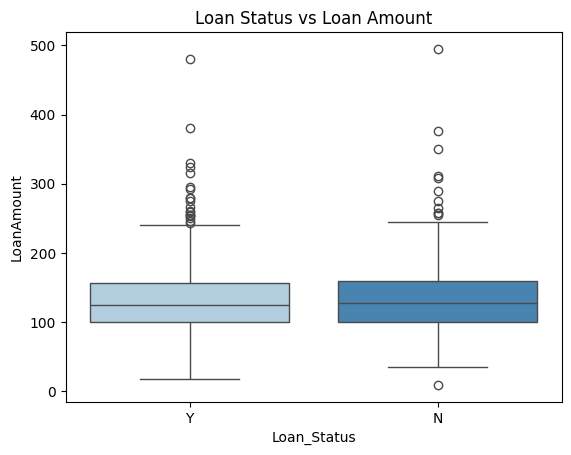

In [264]:
sns.boxplot(x="Loan_Status", y="LoanAmount", hue="Loan_Status", data=df, palette="Blues", legend=False)
plt.title("Loan Status vs Loan Amount")
plt.show()

Loan approvals are granted across a wide range of loan amounts, meaning the requested loan size is not the only deciding factor.

### Loan\_Status vs Credit History

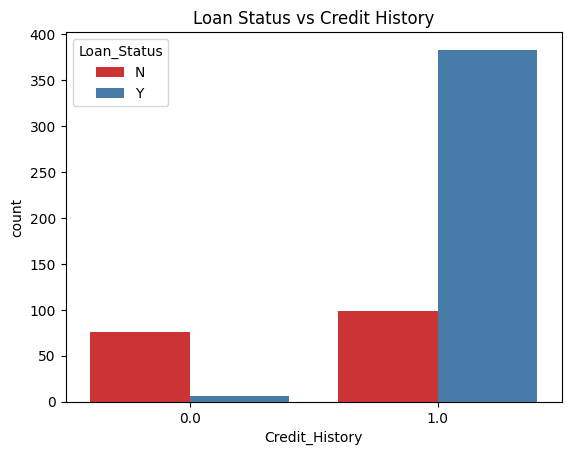

In [265]:
sns.countplot(x="Credit_History", hue="Loan_Status", data=df, palette="Set1")
plt.title("Loan Status vs Credit History")
plt.show()

Applicants with a positive credit history (1) are far more likely to get their loan approved compared to those with no credit history (0).

### Loan\_Status vs Property Area

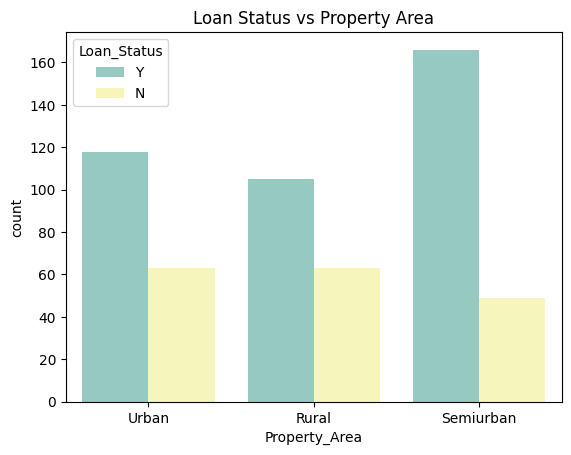

In [266]:
sns.countplot(x="Property_Area", hue="Loan_Status", data=df, palette="Set3")
plt.title("Loan Status vs Property Area")
plt.show()

Urban and semi-urban applicants seem to have better approval chances compared to rural applicants.

## Data Preparation and Model Training

In [267]:
# Convert categorical columns using one-hot encoding
cat_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
df = pd.get_dummies(df, columns=cat_cols)

# Features and target
X = df.drop("Loan_Status", axis=1)
y = df["Loan_Status"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
num_cols = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Train model (SVM)
model = SVC(random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
print(y_pred[:20])

['Y' 'N' 'Y' 'Y' 'Y' 'N' 'Y' 'N' 'N' 'Y' 'Y' 'Y' 'Y' 'Y' 'Y' 'N' 'Y' 'Y'
 'Y' 'Y']


Add Predictions to the Test Set

In [268]:
# Convert X_test to a DataFrame
X_test_df = pd.DataFrame(X_test, columns=X_test.columns)

# Add the predicted values
X_test_df['Loan_Status_Predicted'] = y_pred

# Display the first rows
print(X_test_df.head())

     ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
585         0.045014           0.374594    0.619997         -3.856561   
569        -0.531280           0.085836   -0.541877          0.279941   
255        -0.574102          -0.550912    2.038168          0.279941   
570        -0.401782          -0.011034    0.859207          0.279941   
529         1.334840          -0.550912   -0.097631          0.279941   

     Credit_History  Gender_Female  Gender_Male  Married_No  Married_Yes  \
585        0.439456          False         True       False         True   
569       -2.275540          False         True       False         True   
255        0.439456           True        False        True        False   
570        0.439456          False         True       False         True   
529        0.439456          False         True        True        False   

     Dependents_0  ...  Dependents_2  Dependents_3+  Education_Graduate  \
585         False  ...       

Here we can see the model’s predicted loan approval status (Loan_Status_Predicted) added as a new column. Each row shows the applicant’s features along with whether the model predicts loan approval (Y) or rejection (N).

## Summary

In this project, I worked on predicting loan approval using Machine Learning. The dataset included details like applicant income, co-applicant income, loan amount, credit history, and some demographic info. After cleaning the data and training the model, I was able to predict whether an applicant is likely to get their loan approved (Y) or not (N).

The results show that Machine Learning can be really useful for banks or financial institutions because it can help speed up the decision-making process. Of course, the model isn’t perfect, but it gives a strong starting point to support human judgment with data.